In [1]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 5.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import h5py
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

D0822 19:35:08.253789212      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0822 19:35:08.253809885      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0822 19:35:08.253813543      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0822 19:35:08.253816308      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0822 19:35:08.253819226      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0822 19:35:08.253822297      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0822 19:35:08.253824941      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0822 19:35:08.

In [3]:
with h5py.File('/kaggle/input/vtid2-dataset/vtid2_dataset.h5', 'r') as file:
    images = file['images'][:]
    labels = file['labels'][:]

In [4]:
print('Total number of images: ',len(images))
print('Total number of labels: ',len(labels))

Total number of images:  4356
Total number of labels:  4356


In [5]:
unique_classes, class_counts = np.unique(labels, return_counts=True)
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")

Class b'hatchback': 606 samples
Class b'other': 600 samples
Class b'pickup': 1240 samples
Class b'sedan': 1230 samples
Class b'suv': 680 samples


In [6]:
resized_images = [Image.fromarray(image).resize((224, 224)) for image in images]
resized_images = np.array([preprocess_input(np.array(image)) for image in resized_images])

In [7]:
def adjust_brightness(image, factor):
    image = image.astype(np.float32)
    augmented_image = image + factor
    augmented_image = np.clip(augmented_image, 0, 255)
    augmented_image = augmented_image.astype(np.uint8)
    return augmented_image

def flip_image(image, flip_code):
    return cv2.flip(image, flip_code)

def rotate_image(image, angle):
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(image, M, (cols, rows))

def zoom_image(image, zoom_factor):
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 0, zoom_factor)
    return cv2.warpAffine(image, M, (cols, rows))

def shift_image(image, dx, dy):
    rows, cols = image.shape[:2]
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    return cv2.warpAffine(image, M, (cols, rows))

In [8]:
augmented_images = []
augmented_labels = []

for img, label in zip(resized_images, labels):
    augmented_img_brightness = adjust_brightness(img, 50)

    augmented_img_flip_horizontal = flip_image(img, 1)
    augmented_img_flip_vertical = flip_image(img, 0)

    augmented_img_rotate = rotate_image(img, 30)

    augmented_img_zoom = zoom_image(img, 1.2)

    augmented_img_shift = shift_image(img, 20, 20)

    augmented_images.extend([
        img,
        augmented_img_brightness,
        augmented_img_flip_horizontal,
        augmented_img_flip_vertical,
        augmented_img_rotate,
        augmented_img_zoom,
        augmented_img_shift
    ])

    augmented_labels.extend([label] * 7)

In [9]:
print('Total number of augmented images: ',len(augmented_images))
print('Total number of augmented labels: ',len(augmented_labels))

Total number of augmented images:  30492
Total number of augmented labels:  30492


In [10]:
unique_classes_aug, class_counts_aug = np.unique(augmented_labels, return_counts=True)
for class_label, count in zip(unique_classes_aug, class_counts_aug):
    print(f"Class {class_label}: {count} samples")

Class b'hatchback': 4242 samples
Class b'other': 4200 samples
Class b'pickup': 8680 samples
Class b'sedan': 8610 samples
Class b'suv': 4760 samples


In [11]:
images = np.array(augmented_images)
num_classes = len(np.unique(augmented_labels))
print('Number of classes',num_classes)

Number of classes 5


In [12]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(augmented_labels)
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

In [13]:
labels = to_categorical(encoded_labels, num_classes)
print(np.unique(labels))

[0. 1.]


In [14]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

num_input_features = base_model.layers[-1].output.shape[-1]

x = base_model.layers[-1].output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 [==============================] - 0s 0us/step


In [15]:
k = 3
epochs = 3
batch_size = 32
kf = KFold(n_splits=k, shuffle=True)

accuracy_values = []
precision_values = []
recall_values = []
f1_score_values = []

all_true_labels = []
all_pred_labels = []
model_history = []

for fold, (train_index, test_index) in enumerate(kf.split(images), 1):
    print("Fold:", fold)
    X_train_fold, X_test_fold = images[train_index], images[test_index]
    y_train_fold, y_test_fold = labels[train_index], labels[test_index]

    history = model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size)

    y_pred = model.predict(X_test_fold)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test_fold, axis=1)

    
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    report = classification_report(y_true_labels, y_pred_labels, output_dict=True)
    
    accuracy_values.append(report['accuracy'])
    precision_values.append(report['weighted avg']['precision'])
    recall_values.append(report['weighted avg']['recall'])
    f1_score_values.append(report['weighted avg']['f1-score'])

    all_true_labels.extend(y_true_labels)
    all_pred_labels.extend(y_pred)
    model_history.append(history)
    
avg_accuracy = np.mean(accuracy_values)
avg_weighted_precision = np.mean(precision_values)
avg_weighted_recall = np.mean(recall_values)
avg_weighted_f1_score = np.mean(f1_score_values)

print('Average accuracy:', avg_accuracy)
print('Average weighted precision:', avg_weighted_precision)
print('Average weighted recall:', avg_weighted_recall)
print('Average weighted f1 score:', avg_weighted_f1_score)

Fold: 1
Epoch 1/3
636/636 [==============================] - 303s 470ms/step - loss: 1.6200 - accuracy: 0.5636
Epoch 2/3
636/636 [==============================] - 303s 477ms/step - loss: 0.7256 - accuracy: 0.7080
Epoch 3/3
318/318 [==============================] - 148s 461ms/step
Fold: 2
Epoch 1/3
636/636 [==============================] - 307s 482ms/step - loss: 0.4697 - accuracy: 0.8074
Epoch 2/3
636/636 [==============================] - 307s 482ms/step - loss: 0.4023 - accuracy: 0.8339
Epoch 3/3
318/318 [==============================] - 152s 477ms/step
Fold: 3
Epoch 1/3
636/636 [==============================] - 298s 468ms/step - loss: 0.3308 - accuracy: 0.8601
Epoch 2/3
636/636 [==============================] - 297s 467ms/step - loss: 0.3045 - accuracy: 0.8716
Epoch 3/3
318/318 [==============================] - 144s 454ms/step
Average accuracy: 0.8630132493768858
Average weighted precision: 0.8919559652356576
Average weighted recall: 0.8630132493768858
Average weighted f1 sco

In [16]:
all_pred_labels = np.array(all_pred_labels)
all_true_labels = np.array(all_true_labels)
n_classes = len(np.unique(all_true_labels))
all_true_labels_binarized = label_binarize(all_true_labels, classes=range(n_classes))
true = all_true_labels_binarized.ravel()
pred = all_pred_labels.ravel()

In [17]:
roc_values = pd.DataFrame({
    'True_Class': true,
    'Pred_Class': pred,
})

roc_values.to_csv('/kaggle/working/VTID2_Xception_ROC.csv', index=False)

In [18]:
learning_curves = pd.DataFrame({
    'Precision': precision_values,
    'Recall': recall_values,
    'F1_score': f1_score_values,
})

learning_curves.to_csv('/kaggle/working/VTID2_Xception_Learning.csv', index=False)

In [19]:
history_values = pd.DataFrame({
    'History': model_history
})

history_values.to_csv('/kaggle/working/VTID2_Xception_History.csv', index=False)

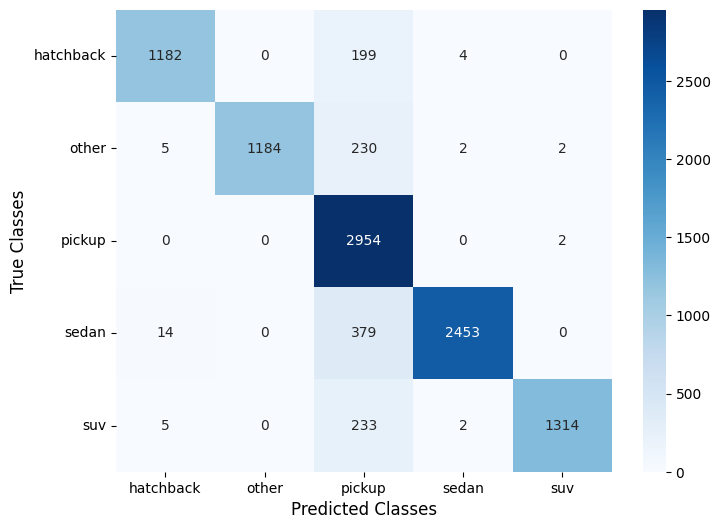

In [20]:
conf_matrix_labels = [label_mapping[i] for i in range(len(label_mapping))]
conf_matrix_labels = [label.decode('utf-8')[0:] for label in conf_matrix_labels]

num_labels = len(conf_matrix_labels)
fig_width = min(max(8, num_labels * 0.5), 12)
fig_height = max(6, num_labels * 0.4)

plt.figure(figsize=(fig_width, fig_height))
plt.rcParams['figure.dpi'] = 300

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=conf_matrix_labels, yticklabels=conf_matrix_labels)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.xlabel("Predicted Classes", fontsize=12)
plt.ylabel("True Classes", fontsize=12)
plt.savefig('/kaggle/working/confusion_matrix1-VTID2_Xception.png', dpi=300, bbox_inches='tight')
plt.show()

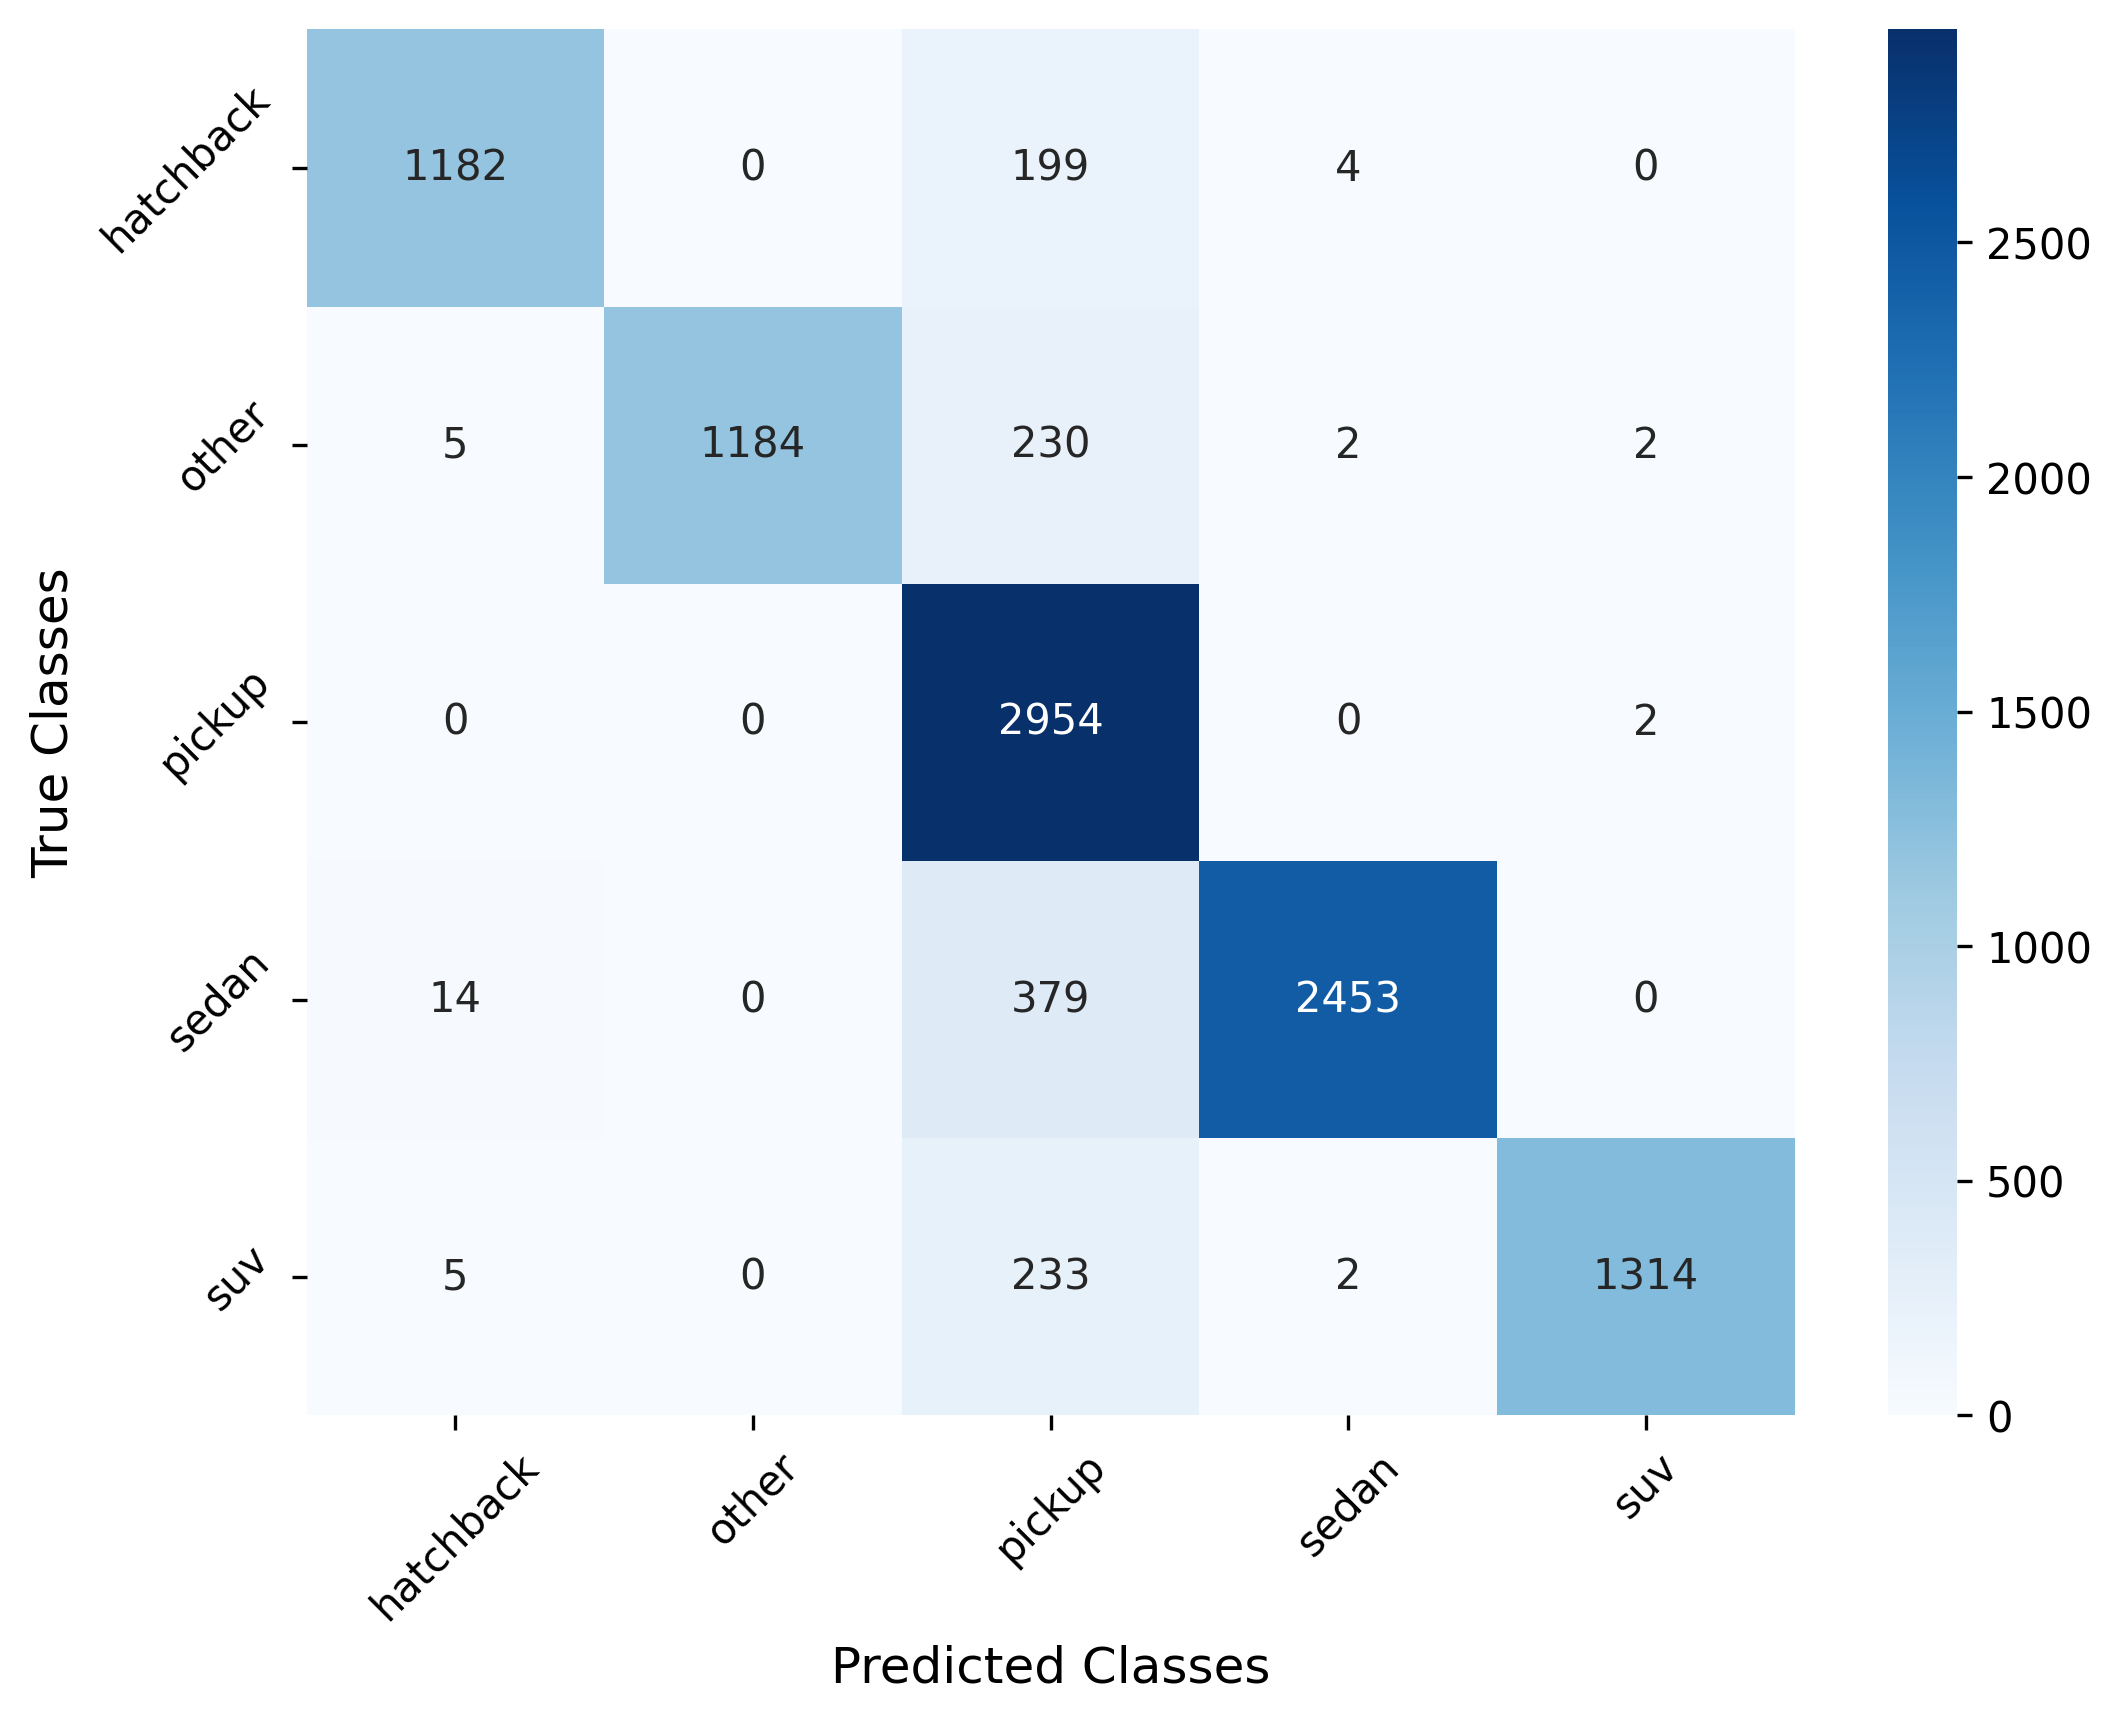

In [21]:
conf_matrix_labels = [label_mapping[i] for i in range(len(label_mapping))]
conf_matrix_labels = [label.decode('utf-8')[0:] for label in conf_matrix_labels]

num_labels = len(conf_matrix_labels)
fig_width = min(max(8, num_labels * 0.5), 12)
fig_height = max(6, num_labels * 0.4)

plt.figure(figsize=(fig_width, fig_height))
plt.rcParams['figure.dpi'] = 300

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=conf_matrix_labels, yticklabels=conf_matrix_labels)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=45, fontsize=10)
plt.xlabel("Predicted Classes", fontsize=12)
plt.ylabel("True Classes", fontsize=12)
plt.savefig('/kaggle/working/confusion_matrix2-VTID2_Xception.png', dpi=300, bbox_inches='tight')
plt.show()